In [1]:
%%capture
!pip install kornia
!pip install kornia-rs
!pip install kornia_moons --no-deps
!pip install opencv-python --upgrade

# DISK

In [2]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename


url_a = "https://github.com/kornia/data/raw/main/matching/kn_church-2.jpg"
url_b = "https://github.com/kornia/data/raw/main/matching/kn_church-8.jpg"
download_image(url_a)
download_image(url_b)

'kn_church-8.jpg'

In [3]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia.feature.adalam import AdalamFilter
from kornia_moons.viz import *

#device = K.utils.get_cuda_or_mps_device_if_available()

device = torch.device("cpu")

print(device)

/Users/victordavidsilva/.pyenv/versions/3.8.10/lib/python3.8/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


cpu


In [4]:
# %%capture
fname1 = "kn_church-2.jpg"
fname2 = "kn_church-8.jpg"

adalam_config = KF.adalam.get_adalam_default_config()
# adalam_config['orientation_difference_threshold'] = None
# adalam_config['scale_rate_threshold'] = None
adalam_config["force_seed_mnn"] = False
adalam_config["search_expansion"] = 16
adalam_config["ransac_iters"] = 256


img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32, device=device)[None, ...]
img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32, device=device)[None, ...]

num_features = 2048
disk = KF.DISK.from_pretrained("depth").to(device)

hw1 = torch.tensor(img1.shape[2:], device=device)
hw2 = torch.tensor(img2.shape[2:], device=device)

match_with_adalam = True

with torch.inference_mode():
    inp = torch.cat([img1, img2], dim=0)
    features1, features2 = disk(inp, num_features, pad_if_not_divisible=True)
    kps1, descs1 = features1.keypoints, features1.descriptors
    kps2, descs2 = features2.keypoints, features2.descriptors
    if match_with_adalam:
        lafs1 = KF.laf_from_center_scale_ori(kps1[None], 96 * torch.ones(1, len(kps1), 1, 1, device=device))
        lafs2 = KF.laf_from_center_scale_ori(kps2[None], 96 * torch.ones(1, len(kps2), 1, 1, device=device))

        dists, idxs = KF.match_adalam(descs1, descs2, lafs1, lafs2, hw1=hw1, hw2=hw2, config=adalam_config)
    else:
        dists, idxs = KF.match_smnn(descs1, descs2, 0.98)


print(f"{idxs.shape[0]} tentative matches with DISK AdaLAM")

Downloading: "https://raw.githubusercontent.com/cvlab-epfl/disk/master/depth-save.pth" to /Users/victordavidsilva/.cache/torch/hub/checkpoints/depth-save.pth
100%|██████████| 4.17M/4.17M [00:00<00:00, 29.2MB/s]


218 tentative matches with DISK AdaLAM


In [5]:
def get_matching_keypoints(kp1, kp2, idxs):
    mkpts1 = kp1[idxs[:, 0]]
    mkpts2 = kp2[idxs[:, 1]]
    return mkpts1, mkpts2


mkpts1, mkpts2 = get_matching_keypoints(kps1, kps2, idxs)

Fm, inliers = cv2.findFundamentalMat(
    mkpts1.detach().cpu().numpy(), mkpts2.detach().cpu().numpy(), cv2.USAC_MAGSAC, 1.0, 0.999, 100000
)
inliers = inliers > 0
print(f"{inliers.sum()} inliers with DISK")

95 inliers with DISK


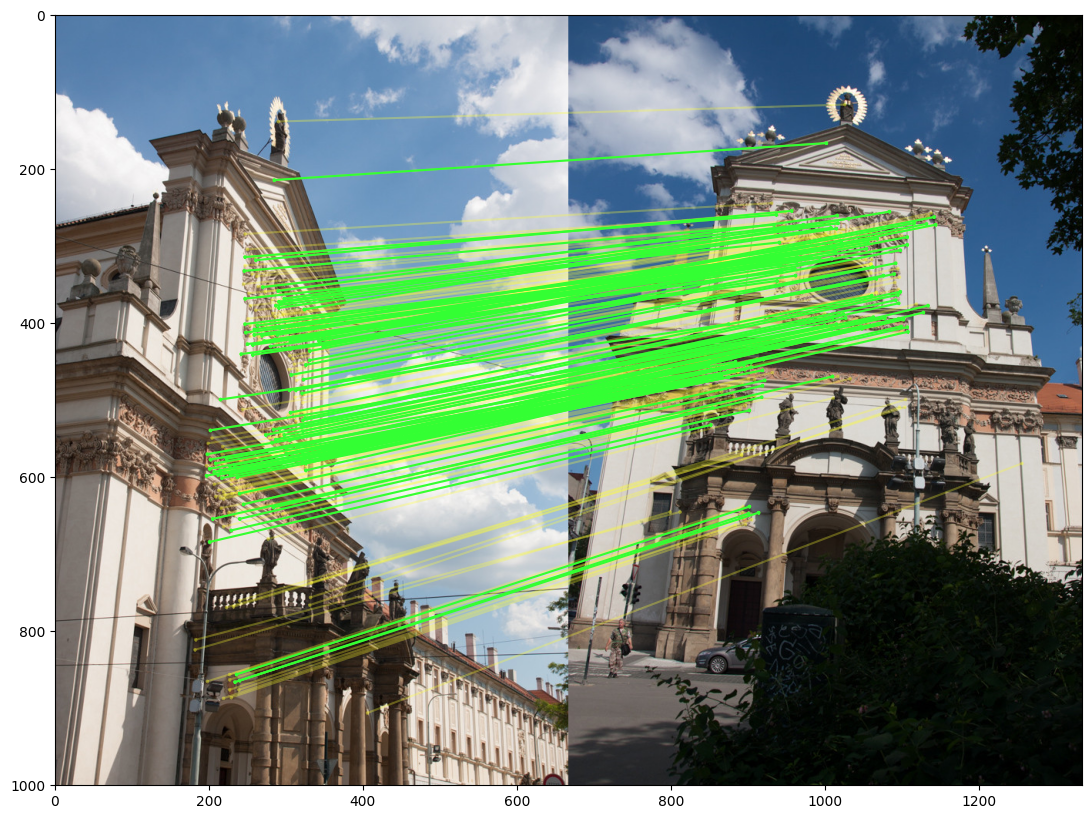

In [6]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(kps1[None].cpu()),
    KF.laf_from_center_scale_ori(kps2[None].cpu()),
    idxs.cpu(),
    K.tensor_to_image(img1.cpu()),
    K.tensor_to_image(img2.cpu()),
    inliers,
    draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
)

# SIFT

cpu
Loaded LightGlue model


/Users/victordavidsilva/.pyenv/versions/3.8.10/lib/python3.8/site-packages/kornia/feature/integrated.py:464: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hw1_ = torch.tensor(hw1, device=dev)
/Users/victordavidsilva/.pyenv/versions/3.8.10/lib/python3.8/site-packages/kornia/feature/integrated.py:468: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hw2_ = torch.tensor(hw2, device=dev)


144 tentative matches with SIFT LightGlue
40 inliers with SIFT


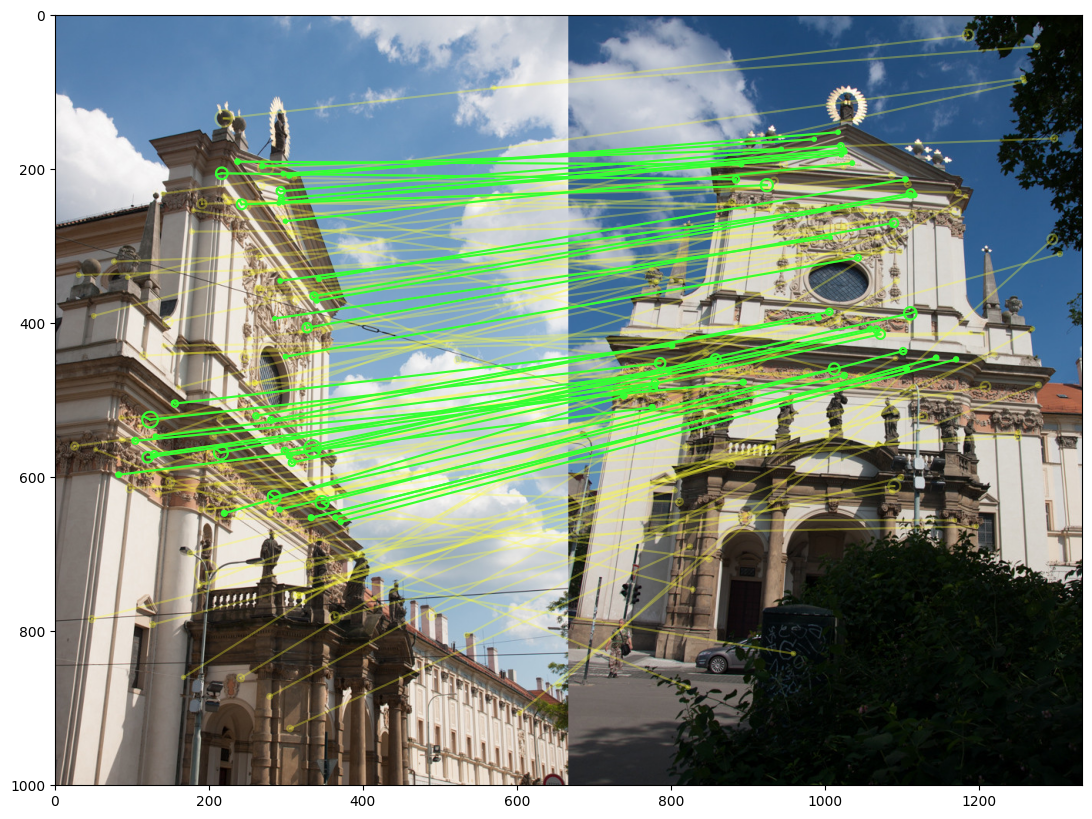

In [9]:


import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia.feature.adalam import AdalamFilter
from kornia_moons.viz import *
import torch.nn.functional as F
#device = K.utils.get_cuda_or_mps_device_if_available()

device = torch.device("cpu")

print(device)
from kornia_moons.feature import OpenCVFeatureKornia
from kornia_moons.viz import draw_LAF_matches
import cv2

fname1 = "kn_church-2.jpg"
fname2 = "kn_church-8.jpg"

device = K.utils.get_cuda_or_mps_device_if_available()
device = torch.device('cpu') 

img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32, device=device)[None, ...]
img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32, device=device)[None, ...]

hw1 = torch.tensor(img1.shape[2:], device=device)
hw2 = torch.tensor(img2.shape[2:], device=device)

opencv_sift = OpenCVFeatureKornia(cv2.SIFT_create(4096), mrSize=1.0)

lg_matcher = KF.LightGlueMatcher("sift").eval().to(device)

use_opencv_sift = False
with torch.inference_mode():
    lafs1, r1, descs1 = opencv_sift(img1.to(device))
    lafs2, r2, descs2 = opencv_sift(img2.to(device))
    # LightGlue SIFT is RootSIFT in reality, so we have to convert to RootSIFT
    descs1 = F.normalize(descs1, dim=-1, p=1).sqrt()
    descs2 = F.normalize(descs2, dim=-1, p=1).sqrt()
    dists, idxs = lg_matcher(descs1[0], descs2[0], 
                             lafs1, lafs2, hw1=hw1, hw2=hw2)
    

print(f"{idxs.shape[0]} tentative matches with SIFT LightGlue")

def get_matching_keypoints(kp1, kp2, idxs):
    mkpts1 = kp1[idxs[:, 0]]
    mkpts2 = kp2[idxs[:, 1]]
    return mkpts1, mkpts2


kps1 = KF.get_laf_center(lafs1)[0]
kps2 = KF.get_laf_center(lafs2)[0]

mkpts1, mkpts2 = get_matching_keypoints(KF.get_laf_center(lafs1)[0],
                                        KF.get_laf_center(lafs2)[0], idxs)

Fm, inliers = cv2.findFundamentalMat(
    mkpts1.detach().cpu().numpy(), mkpts2.detach().cpu().numpy(), cv2.USAC_MAGSAC, 1.0, 0.999, 100000
)
inliers = inliers > 0
print(f"{inliers.sum()} inliers with SIFT")

draw_LAF_matches(
    lafs1,
    lafs2,
    idxs.cpu(),
    K.tensor_to_image(img1.cpu()),
    K.tensor_to_image(img2.cpu()),
    inliers,
    draw_dict={"inlier_color": (0.2, 1, 0.2), 
               "tentative_color": (1, 1, 0.2, 0.3), 
               "feature_color": None, "vertical": False},
)

In [8]:
import kornia as K
import kornia.feature as KF
import cv2
from kornia_moons.feature import OpenCVFeatureKornia
from kornia_moons.viz import draw_LAF_matches
import torch
import torch.nn.functional as F

fname1 = "kn_church-2.jpg"
fname2 = "kn_church-8.jpg"

device = K.utils.get_cuda_or_mps_device_if_available()
device = torch.device('cpu')  # Forzar uso de CPU

img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32, device=device)[None, ...]
img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32, device=device)[None, ...]

hw1 = torch.tensor(img1.shape[2:], device=device)
hw2 = torch.tensor(img2.shape[2:], device=device)

# Cambiar SIFT por ORB:
opencv_orb = OpenCVFeatureKornia(cv2.ORB_create(nfeatures=4096), mrSize=1.0)

# Cambiar el matcher a tipo "orb"
lg_matcher = KF.LightGlueMatcher("orb").eval().to(device)

with torch.inference_mode():
    lafs1, r1, descs1 = opencv_orb(img1.to(device))
    lafs2, r2, descs2 = opencv_orb(img2.to(device))
    # Con ORB, no se recomienda normalizar los descriptores como se hace para SIFT, así que removemos esas líneas.
    dists, idxs = lg_matcher(descs1[0], descs2[0], lafs1, lafs2, hw1=hw1, hw2=hw2)
    
print(f"{idxs.shape[0]} tentative matches with ORB LightGlue")

def get_matching_keypoints(kp1, kp2, idxs):
    mkpts1 = kp1[idxs[:, 0]]
    mkpts2 = kp2[idxs[:, 1]]
    return mkpts1, mkpts2

kps1 = KF.get_laf_center(lafs1)[0]
kps2 = KF.get_laf_center(lafs2)[0]

mkpts1, mkpts2 = get_matching_keypoints(
    KF.get_laf_center(lafs1)[0],
    KF.get_laf_center(lafs2)[0],
    idxs
)

Fm, inliers = cv2.findFundamentalMat(
    mkpts1.detach().cpu().numpy(), mkpts2.detach().cpu().numpy(),
    cv2.USAC_MAGSAC, 1.0, 0.999, 100000
)
inliers = inliers > 0
print(f"{inliers.sum()} inliers with ORB")

draw_LAF_matches(
    lafs1,
    lafs2,
    idxs.cpu(),
    K.tensor_to_image(img1.cpu()),
    K.tensor_to_image(img2.cpu()),
    inliers,
    draw_dict={
        "inlier_color": (0.2, 1, 0.2),
        "tentative_color": (1, 1, 0.2, 0.3),
        "feature_color": None,
        "vertical": False
    },
)


NotImplementedError: orb is not supported. Try one of ['aliked', 'dedodeb', 'dedodeg', 'disk', 'dog_affnet_hardnet', 'doghardnet', 'keynet_affnet_hardnet', 'sift', 'superpoint']

# ORB

In [3]:
import io
import requests

def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    bytesio = io.BytesIO(requests.get(url).content)
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())
    return filename

url_a = "https://github.com/kornia/data/raw/main/matching/kn_church-2.jpg"
url_b = "https://github.com/kornia/data/raw/main/matching/kn_church-8.jpg"
download_image(url_a)
download_image(url_b)

import kornia as K
import kornia.feature as KF
import cv2
from kornia_moons.feature import OpenCVFeatureKornia
from kornia_moons.viz import draw_LAF_matches
import torch

fname1 = "kn_church-2.jpg"
fname2 = "kn_church-8.jpg"

device = K.utils.get_cuda_or_mps_device_if_available()
device = torch.device('cpu')  # Forzamos el uso de CPU

img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32, device=device)[None, ...]
img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32, device=device)[None, ...]

hw1 = torch.tensor(img1.shape[2:], device=device)
hw2 = torch.tensor(img2.shape[2:], device=device)

# Utilizamos ORB en lugar de SIFT:
opencv_orb = OpenCVFeatureKornia(cv2.ORB_create(nfeatures=1028), mrSize=0.50)


/Users/victordavidsilva/.pyenv/versions/3.8.10/lib/python3.8/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


260 tentative matches with ORB (BFMatcher)
26 inliers with ORB (BFMatcher)


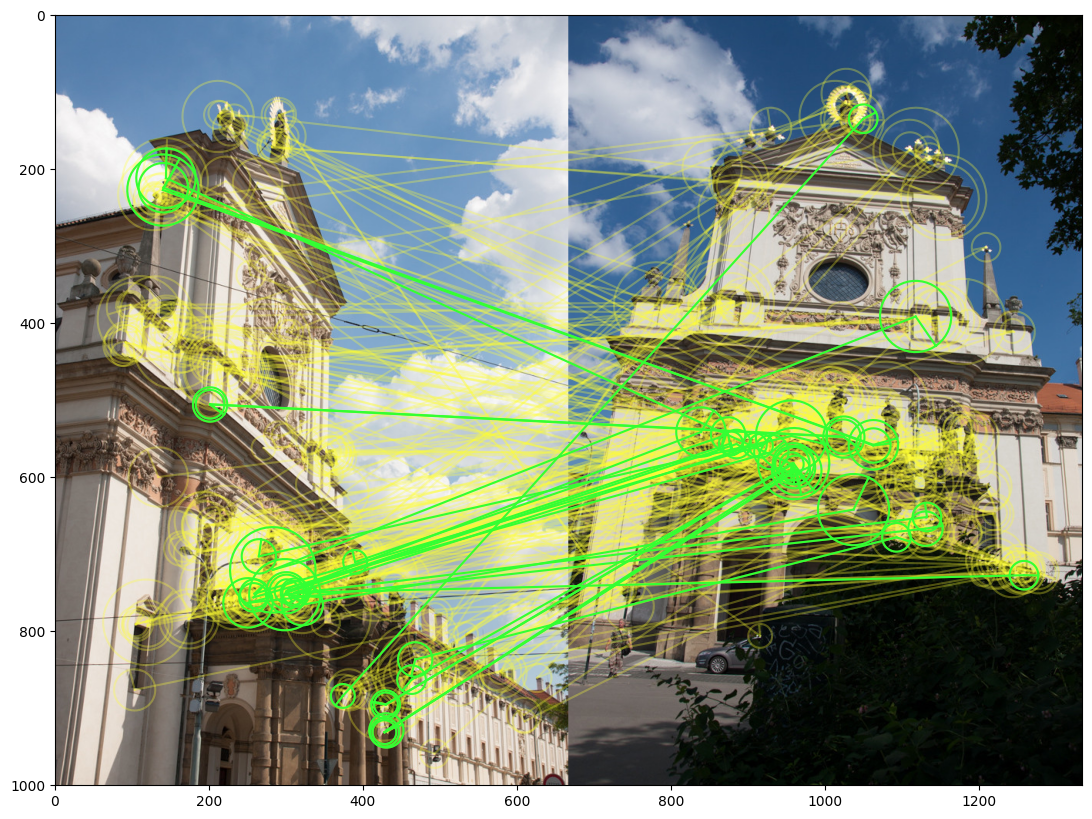

In [4]:
with torch.inference_mode():
    lafs1, r1, descs1 = opencv_orb(img1.to(device))
    lafs2, r2, descs2 = opencv_orb(img2.to(device))

# Como los descriptores ORB son binarios, usamos BFMatcher con NORM_HAMMING.
# Convertimos los descriptores a numpy:
descs1_np = descs1[0].cpu().numpy()
descs2_np = descs2[0].cpu().numpy()

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descs1_np, descs2_np)
matches = sorted(matches, key=lambda x: x.distance)

# Convertir los matches a índices:
idxs = torch.tensor([[m.queryIdx, m.trainIdx] for m in matches], dtype=torch.int32)

print(f"{idxs.shape[0]} tentative matches with ORB (BFMatcher)")

def get_matching_keypoints(kp1, kp2, idxs):
    mkpts1 = kp1[idxs[:, 0]]
    mkpts2 = kp2[idxs[:, 1]]
    return mkpts1, mkpts2

kps1 = KF.get_laf_center(lafs1)[0]
kps2 = KF.get_laf_center(lafs2)[0]

mkpts1, mkpts2 = get_matching_keypoints(kps1, kps2, idxs)

Fm, inliers = cv2.findFundamentalMat(
    mkpts1.detach().cpu().numpy(), mkpts2.detach().cpu().numpy(),
    cv2.USAC_MAGSAC, 1.0, 0.999, 100000
)
inliers = inliers > 0
print(f"{inliers.sum()} inliers with ORB (BFMatcher)")


draw_LAF_matches(
    lafs1,
    lafs2,
    idxs.cpu(),
    K.tensor_to_image(img1.cpu()),
    K.tensor_to_image(img2.cpu()),
    inliers,
    draw_dict={
        "inlier_color": (0.2, 1, 0.2),
        "tentative_color": (1, 1, 0.2, 0.3),
        "feature_color": None,
        "vertical": False
    },
)


In [5]:
Fm

array([[ 3.64443717e-05, -5.81773135e-06, -6.49311472e-03],
       [-6.75528376e-05,  4.21419684e-05, -1.15896648e-02],
       [ 2.86704161e-02, -2.28322871e-02,  8.64558679e+00]])

In [12]:
def get_matching_keypoints(kp1, kp2, idxs):
    mkpts1 = kp1[idxs[:, 0]]
    mkpts2 = kp2[idxs[:, 1]]
    return mkpts1, mkpts2

def find_fundamental_matrix(f1,f2):  
    img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32, device=device)[None, ...]
    img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32, device=device)[None, ...]

    hw1 = torch.tensor(img1.shape[2:], device=device)
    hw2 = torch.tensor(img2.shape[2:], device=device)

    # Utilizamos ORB en lugar de SIFT:
    opencv_orb = OpenCVFeatureKornia(cv2.ORB_create(nfeatures=1028), mrSize=0.50)

    with torch.inference_mode():
        lafs1, r1, descs1 = opencv_orb(img1.to(device))
        lafs2, r2, descs2 = opencv_orb(img2.to(device))

    #print("r1",r1)
    #print("r2",r2)

    # Como los descriptores ORB son binarios, usamos BFMatcher con NORM_HAMMING.
    # Convertimos los descriptores a numpy:
    descs1_np = descs1[0].cpu().numpy()
    descs2_np = descs2[0].cpu().numpy()

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descs1_np, descs2_np)
    matches = sorted(matches, key=lambda x: x.distance)

    # Convertir los matches a índices:
    idxs = torch.tensor([[m.queryIdx, m.trainIdx] for m in matches], dtype=torch.int32)

    print(f"{idxs.shape[0]} tentative matches with ORB (BFMatcher)")

    kps1 = KF.get_laf_center(lafs1)[0]
    kps2 = KF.get_laf_center(lafs2)[0]

    mkpts1, mkpts2 = get_matching_keypoints(kps1, kps2, idxs)

    Fm, inliers = cv2.findFundamentalMat(
        mkpts1.detach().cpu().numpy(), mkpts2.detach().cpu().numpy(),
        cv2.USAC_MAGSAC, 1.0, 0.999, 100000
    )
    inliers = inliers > 0
    print(f"{inliers.sum()} inliers with ORB (BFMatcher)")

    #print("mkpts1 inliers", mkpts1[inliers])
    #print("mkpts2 inliers", mkpts2[inliers])

    return mkpts1, mkpts2, Fm

mkpts1, mkpts2, Rt = find_fundamental_matrix(fname1, fname2)
print("Fundamental matriz: ",Rt)
print("Cantidad de puntos que se corresponden en el frame 1: ", len(mkpts1))
print("Cantidad de puntos que se corresponden en el frame 2: ", len(mkpts2))

260 tentative matches with ORB (BFMatcher)
26 inliers with ORB (BFMatcher)
Fundamental matriz:  [[ 3.64443717e-05 -5.81773135e-06 -6.49311472e-03]
 [-6.75528376e-05  4.21419684e-05 -1.15896648e-02]
 [ 2.86704161e-02 -2.28322871e-02  8.64558679e+00]]
Cantidad de puntos que se corresponden en el frame 1:  260
Cantidad de puntos que se corresponden en el frame 2:  260


In [13]:
import numpy as np

# Camera intrinsic
W, H = 1920//2 , 1080//2
F = 450
Kint = np.array([[F, 0, W//2], [0, F, H//2], [0,0,1]])

Kinv = np.linalg.inv(Kint)

# Display
#mapp = Map()
#mapp.create_viewer()

def add_ones(x):
    # A x le añade una columna de 1s para convertirlo en coordenadas homogéneas
    # representando cada punto como [x,y,1]
    return np.concatenate([x, np.ones((x.shape[0],1))], axis = 1)

def triangulate(pose1, pose2, pts1, pts2):
    # Crea una matriz de ceros del la cantidad de filas de pts1 y 4 columnas
    ret = np.zeros((pts1.shape[0], 4))

    # Al invertirla, se obtiene la transformación inversa (de la cámara al mundo), 
    # lo que es necesario para la triangulación en un sistema homogéneo.
    pose1 = np.linalg.inv(pose1)
    pose2 = np.linalg.inv(pose2)

    # Meidante add_ones convierte cada punto en coordenadas homgéneas añadiendo
    # un 1 al final (u,v,1)
    for i, p in enumerate(zip(add_ones(pts1), add_ones(pts2))):
        A = np.zeros((4,4))

        #A[0]=u1 (P1)3−(P1)1 
        A[0] = p[0][0] * pose1[2] - pose1[0]
        #A[0]=v1 (P1)3−(P1)2
        A[1] = p[0][1] * pose1[2] - pose1[1]
        #A[0]=u2 (P2)3−(P2)1
        A[2] = p[1][0] * pose2[2] - pose2[0]
        #A[0]=v2 (P2)3−(P2)2
        A[3] = p[1][1] * pose2[2] - pose2[1]

        # Dado que el sistema es homogéneo se busca la solución no trivial. 
        # Esto se hace mediante la descomposición en valores singulares (SVD)
        _, _, vt = np.linalg.svd(A)

        # La solución del sistema homogéneo corresponde al vector asociado al 
        # menor valor singular ya que las filas de vt son los vectores singulares 
        # transpuestos ordenados de mayor a menor valor singular.
        ret[i] = vt[3]

    # Regresa los puntos 3D en coordenadas homogéneas
    return ret

In [14]:
# Se actualiza la pose de f1 usando Rt y f2
fname1_pose = np.dot(Rt, fname2)

# Se triangulan los puntos 3D
pts4d = triangulate(fname1_pose, fname2, mkpts1, mkpts2)

# Para pasar a coordenadas homgénesas se divide por la cuarta componente
pts4d /= pts4d[:,3:]

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U15')) -> None

'kn_church-8.jpg'

In [10]:
fname1[mkpts1]

TypeError: only integer tensors of a single element can be converted to an index

### Modificando la función extractor

In [ ]:
import cv2
import numpy as np
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform
import g2o

# Inicializar matriz identidad de 4x4
IRt = np.eye(4)


def add_ones(x):
    # A x le añade una columna de 1s para convertirlo en coordenadas homogéneas
    # representando cada punto como [x,y,1]
    return np.concatenate([x, np.ones((x.shape[0],1))], axis = 1)


def extractPose(F):
    '''
    Recibe la matriz fundamental y se extrae de ella la pose (rot. y trasl.)
    '''
    # Definir la matriz para computar la rotación
    W = np.asmatrix([[0,-1,0],[1,0,0],[0,0,1]])

    # Singular Value Decomposition (SVD) de la matriz fundamental
    U,d,Vt = np.linalg.svd(F)

    # Verificar que U tenga determinante positivo para asegurarse de que las
    # rotaciones son válidas y evitar reflexiones (si det(U)<0), en caso de 
    # ocurrir se interrumpe el programa y lanza un error.
    assert np.linalg.det(U) > 0

    # Corrige Vt si su determinante es negativo para asegurar una matriz de 
    # rotación apropiada 
    if np.linalg.det(Vt) < 0:
        Vt *= -1

    # Calcular la matriz de rotación: R=U⋅W⋅Vt
    R = np.dot(np.dot(U,W),Vt)

    # Si la traza es negativa se usa W.T para que la rotación sea válida
    if np.sum(R.diagonal()) < 0:
        R = np.dot(np.dot(U,W.T),Vt)

    # Tomar la tercera columna de U como vector de traslación
    t = U[:,2]

    # Inicializar matriz ret como una matriz identidad de 4x4
    ret = np.eye(4)

    # Asignar a la matriz cuadrada de 3x3 la matriz R
    ret[:3,:3] = R

    # Asingar al vector de 3x1 el vector t
    ret[:3,3] = t

    print(d)

    return ret


def extract(img):
    '''
    Obtiene puntos de interes y sus descriptores de una imagen img
    '''
    # Crea un instancia de orb
    #orb = cv2.ORB_create()
    orb = OpenCVFeatureKornia(cv2.ORB_create(nfeatures=1028), mrSize=0.50)

    # Convertir a escala de grises la imagen
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    with torch.inference_mode():
        lafs1, r1, descs = opencv_orb(img.to(device))

    # Como los descriptores ORB son binarios, usamos BFMatcher con NORM_HAMMING.
    # Convertimos los descriptores a numpy:
    descs_np = descs[0].cpu().numpy()

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descs_np, descs2_np)
    matches = sorted(matches, key=lambda x: x.distance)

    # Convertir los matches a índices:
    idxs = torch.tensor([[m.queryIdx, m.trainIdx] for m in matches], dtype=torch.int32)

    print(f"{idxs.shape[0]} tentative matches with ORB (BFMatcher)")



    # Extracción de 8000 puntos con una calidad mínima de 0.01 y una separación
    # mínima de 10
    pts = cv2.goodFeaturesToTrack(gray_img, 8000, qualityLevel = 0.01, minDistance = 10)
    
    # Si pts es None, devuelve un array vacío y None.
    if pts is None:
        return np.array([]), None
    
    # Extracción
    kps = [cv2.KeyPoint(f[0][0], f[0][1], 20) for f in pts]
    kps, des = orb.compute(gray_img, kps)

    return np.array([(kp.pt[0],kp.pt[1]) for kp in kps]), des


def normalize(Kinv, pts):
    return np.dot(Kinv, add_ones(pts).T).T[:, 0:2]


def denormalize(K, pt):
    ret = np.dot(K, [pt[0],pt[1],1.0])
    ret/= ret[2]
    return int(round(ret[0])), int(round(ret[1]))


class Matcher(object):
    def __init__(self):
        self.last = None


def match_frames(f1,f2):
    
    orb = OpenCVFeatureKornia(cv2.ORB_create(nfeatures=1028), mrSize=0.50)

    # Convertir a escala de grises la imagen
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    with torch.inference_mode():
        lafs1, r1, descs = opencv_orb(img.to(device))

    # Como los descriptores ORB son binarios, usamos BFMatcher con NORM_HAMMING.
    # Convertimos los descriptores a numpy:
    descs_np = descs[0].cpu().numpy()

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descs_np, descs2_np)
    matches = sorted(matches, key=lambda x: x.distance)

    # Convertir los matches a índices:
    idxs = torch.tensor([[m.queryIdx, m.trainIdx] for m in matches], dtype=torch.int32)

    print(f"{idxs.shape[0]} tentative matches with ORB (BFMatcher)")




    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(f1.des, f2.des, k=2)

    # Lowie's radio test
    ret = []
    idx1, idx2 = [], []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            p1 = f1.pts[m.queryIdx]
            p2 = f2.pts[m.trainIdx]

            if np.linalg.norm((p1-p2)) < 0.1:
                # Mantener idx
                idx1.append(m.queryIdx)
                idx2.append(m.trainIdx)
                ret.append((p1,p2))
                pass
    assert len(ret) > 8
    ret = np.array(ret)
    idx1 = np.array(idx1)
    idx2 = np.array(idx2)

    # Matiz de fit
    model, inliers = ransac((ret[:,0], ret[:,1]), 
                            FundamentalMatrixTransform,
                            min_samples=8, 
                            residual_threshold = 0.005,
                            max_trials = 200)
    
    # Ignore outliers
    ret = ret[inliers]
    Rt = extractPose(model.params)

    return idx1[inliers], idx2[inliers], Rt

class Frame(object):
    def __init__(self, mapp, img, K):
        self.K = K
        self.Kinv = np.linalg.inv(self.K)
        self.pose = IRt
        self.id = len(mapp.frames) # Cantidad de frames?
        
        mapp.frames.append(self)

        pts, self.des = extract(img)

        # Si des no está vacío
        if self.des.any() != None: 
            self.pts = normalize(self.Kinv, pts)

# LoFTR

In [2]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename

import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia_moons.viz import draw_LAF_matches

/Users/victordavidsilva/.pyenv/versions/3.8.10/lib/python3.8/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [3]:
%%capture

download_image("https://github.com/zju3dv/LoFTR/raw/master/assets/scannet_sample_images/scene0711_00_frame-001680.jpg")
download_image("https://github.com/zju3dv/LoFTR/raw/master/assets/scannet_sample_images/scene0711_00_frame-001995.jpg")

matcher = KF.LoFTR(pretrained="indoor_new")

In [4]:
fname1 = "scene0711_00_frame-001680.jpg"
fname2 = "scene0711_00_frame-001995.jpg"

img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32)[None, ...]
img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32)[None, ...]

img1 = K.geometry.resize(img1, (480, 640), antialias=True)
img2 = K.geometry.resize(img2, (480, 640), antialias=True)

matcher = KF.LoFTR(pretrained="indoor_new")

input_dict = {
    "image0": K.color.rgb_to_grayscale(img1),  # LofTR works on grayscale images only
    "image1": K.color.rgb_to_grayscale(img2),
}

with torch.inference_mode():
    correspondences = matcher(input_dict)

mkpts0 = correspondences["keypoints0"].cpu().numpy()
mkpts1 = correspondences["keypoints1"].cpu().numpy()
Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 1.0, 0.999, 100000)
inliers = inliers > 0


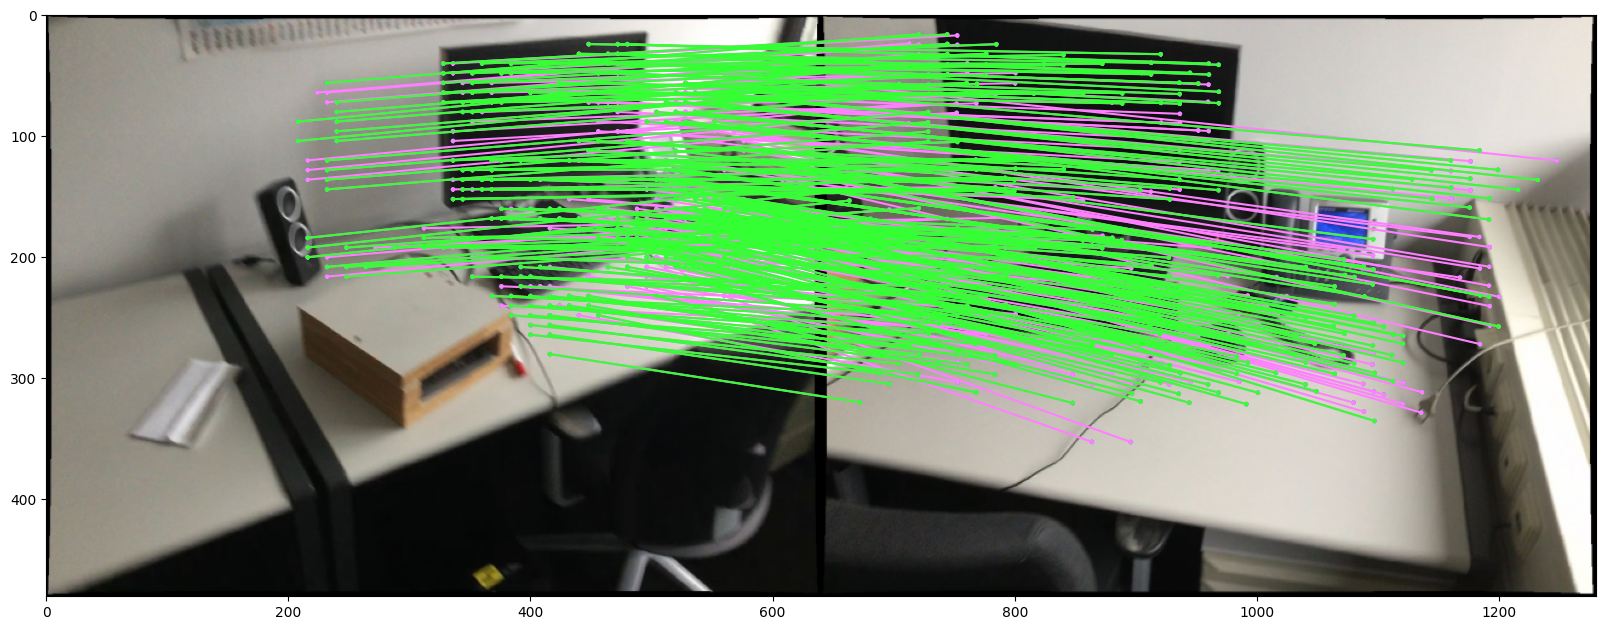

In [5]:

draw_LAF_matches(
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts0).view(1, -1, 2),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1),
    ),
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts1).view(1, -1, 2),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1),
    ),
    torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={
        "inlier_color": (0.2, 1, 0.2),
        "tentative_color": (1.0, 0.5, 1),
        "feature_color": (0.2, 0.5, 1),
        "vertical": False,
    },
)